In [14]:
!pip install pennylane

**Skills Required for Presentation**
To present this project, you should have a good understanding of the following:

Quantum computing basics, including qubits, gates, and quantum circuits.
PennyLane library for quantum machine learning.
TensorFlow and Keras for classical machine learning.
Convolutional Neural Networks (CNNs) and their applications in image classification.
Basic plotting techniques using Matplotlib and optional styling with Seaborn.

**Quantum Convolution**
Same idea can be used in quantum variational circuits.

A small region of the input image 
 square (in our examples) is embedded into a quantum circuit. We achieve this with the help of parameterized rotations applied to the qubits intialized in the ground state.

A quantum computation, associated to a unitary 
, is performed on the system. The unitary could be generated by a variational quantum circuit, or by a random circuit.

The quantum system is finally measured, obtaining a list of classical expectation values. The measurement results could also be classicaly post-processed.

Analogously to a classical convolutional layer, each expectation value is mapped to a different channel of a single output pixel

Iterating the same procedure over different regions, we can scan the entire image, producing an output object which will be structured as multi-channel image.

The quantum convolution can be followed by further quantum layers or by classical layers.

In [15]:
!pip install tensorflow

**Importing basic libraries**
This section imports necessary libraries for the project:
pennylane: A library for quantum machine learning.
numpy from pennylane: NumPy-like functionality tailored for quantum computing.
RandomLayers: A PennyLane template for constructing random quantum circuits.
tensorflow: TensorFlow library for machine learning.
matplotlib.pyplot: A library for creating static, animated, and interactive visualizations in Python.

In [16]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

**Setting the main hyper-parameters**
These parameters define the number of epochs, layers in the quantum circuit, sizes of the training and test datasets, save path, and whether to preprocess data or not.

In [17]:
n_epochs = 30    # number of epochs to run
n_layers = 5    # number of random layers
n_train = 80    # size of training dataset
n_test = 20    # size of test dataset



SAVE_PATH = 'qcnn/'   # where to save
PREPROCESS = True    # if false, skip quantum processing and load data from saved path

np.random.seed(135)
tf.random.set_seed(135)

**Load the dataset**
We will work with the MNIST dataset, which is already available in tensorflow.
This section loads the Fashion-MNIST dataset.

In [18]:
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


We will only be working with a small subset of the entire problem

In [19]:
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]

# for the test data
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]
     

**Normalizing the data**
It preprocesses the data by scaling pixel values to the range [0, 1].
It converts the images into NumPy arrays and adds a new axis to make them compatible with the quantum circuit.

In [20]:
train_images = train_images / 255
test_images = test_images / 255
     

**Adding an extra dimension for the convolutional channels**

In [21]:

train_images = np.array(train_images[..., tf.newaxis], requires_grad = False)

test_images = np.array(test_images[..., tf.newaxis], requires_grad = False)


**Quantum Circuit as a convolution kernel**
We follow the scheme described below. We initialize the Pennylane default.qubit device, simulating a system of 4 Qubits. The associated qnode represents the quantum circuit consisiting of:

an embedding layer of local 
 rotations (with angles scaled by a factor of 
)
a random circuit of n_layers
a final measurement in the computational basis, estimating 
 expectation values.

**Setting Up Quantum Device and Circuit**
This defines the quantum device with 4 qubits.
It generates random parameters for the quantum circuit.
This defines the quantum circuit using PennyLane's QNode decorator.

In [22]:
dev = qml.device('lightning.qubit', wires=4)

# now the random circuit

rand_params = np.random.uniform(high=2*np.pi, size = (n_layers,4))

@qml.qnode(dev)

def circuit(phi):
  # encoding of 4 classical input
  for j in range(4):

    qml.RY(np.pi *phi[j], wires = j)


  # random circuit

  RandomLayers(rand_params, wires = list(range(4)))


  # Measurement
  return [qml.expval(qml.PauliZ(j)) for j in range(4)]

**The convolutional Scheme**
the image is divided into squares of 
 pixels
each square is processed by the quantum circuit
the 
 expectation values are mapped into 
 different channels of a single output pixel.
 
 **Quantum Image Convolution**
 This function performs quantum convolution on the input image using the defined quantum circuit.
 This preprocesses the images using quantum convolution and saves them to files if PREPROCESS is set to True.

This defines a quantum circuit using Pennylane. It creates a device with 4 qubits (quantum bits), generates random parameters for the circuit, and defines a function circuit that takes classical input (phi) and performs the following:

Encodes the classical input onto the qubits using RY rotations.
Applies a sequence of random layers using RandomLayers template.
Measures the qubits in the Z-basis and returns the expectation values.

In [23]:

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

**Quantum Preprocessing**
Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset. Later an entirely classical model will be directly trained and tested on the pre-processed dataset, avoiding unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder SAVE_PATH. Once saved, they can be directly loaded by setting PREPROCESS = False, otherwise the quantum convolution is evaluated at each run of the code.

This section conditionally performs quantum image processing (quanv) on the training and testing images depending on the PREPROCESS flag. If True, it processes the images and saves them. Otherwise, it loads the preprocessed data from saved files.

In [24]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save( "q_train_images.npy", q_train_images)
    np.save( "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load( "q_train_images.npy")
q_test_images = np.load( "q_test_images.npy")

Quantum pre-processing of train images:
80/80        
Quantum pre-processing of test images:


**Visualize**

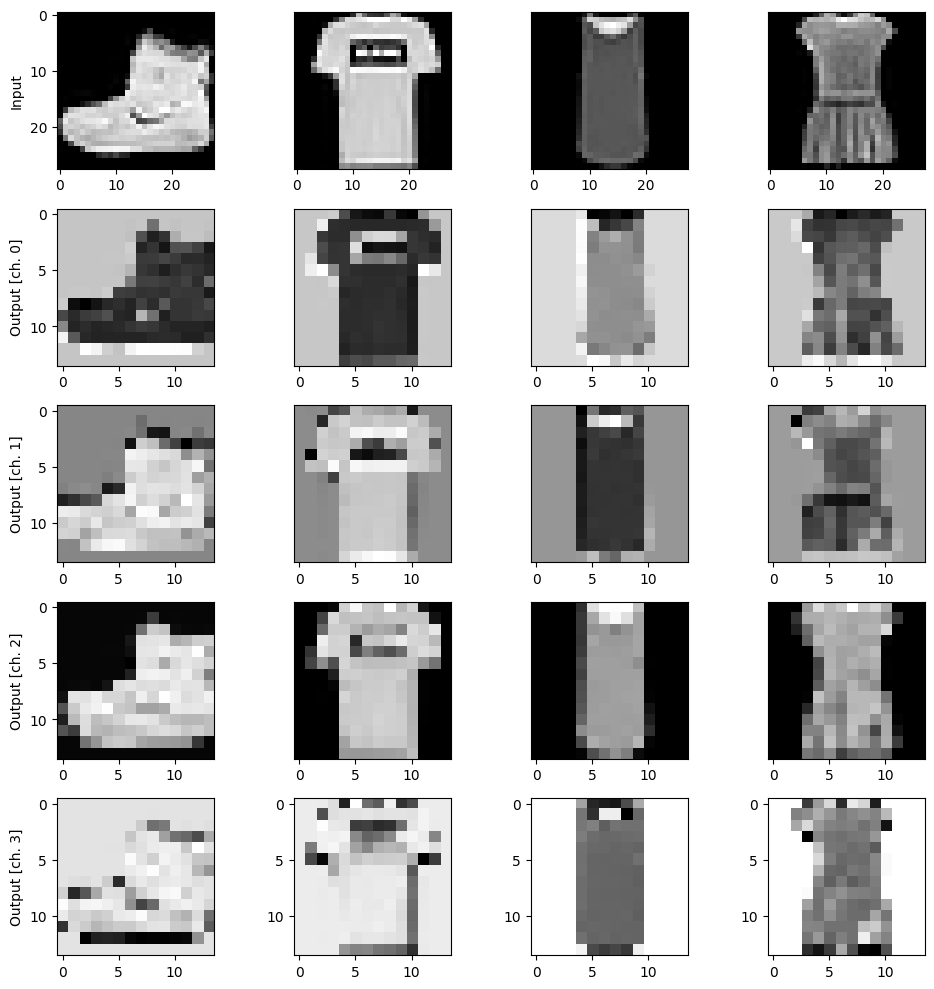

In [25]:
import matplotlib.pyplot as plt
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()


**Hybrid quantum-classical model**
After the application of the quantum convolution layer we feed the resulting features into a classical neural network that will be trained to classify the 10 different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output nodes with a final softmax activation function.

The model is compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function.


This defines a function MyModel that creates a simple Keras classification model. It flattens the input data (transforms from a 2D image to a 1D vector), adds a dense layer with 10 neurons and softmax activation for 10 class probabilities, and configures the model for training with Adam optimizer, categorical crossentropy loss, and accuracy metric.

In [26]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

**Training**
We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution

In [27]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
20/20 - 2s - 103ms/step - accuracy: 0.2625 - loss: 2.2139 - val_accuracy: 0.3500 - val_loss: 1.8709
Epoch 2/30
20/20 - 0s - 5ms/step - accuracy: 0.5250 - loss: 1.6005 - val_accuracy: 0.4000 - val_loss: 1.5903
Epoch 3/30
20/20 - 0s - 5ms/step - accuracy: 0.6875 - loss: 1.3087 - val_accuracy: 0.5500 - val_loss: 1.3872
Epoch 4/30
20/20 - 0s - 6ms/step - accuracy: 0.7625 - loss: 1.1100 - val_accuracy: 0.6500 - val_loss: 1.2525
Epoch 5/30
20/20 - 0s - 5ms/step - accuracy: 0.8000 - loss: 0.9592 - val_accuracy: 0.7500 - val_loss: 1.1535
Epoch 6/30
20/20 - 0s - 5ms/step - accuracy: 0.8375 - loss: 0.8420 - val_accuracy: 0.7500 - val_loss: 1.0782
Epoch 7/30
20/20 - 0s - 5ms/step - accuracy: 0.8750 - loss: 0.7490 - val_accuracy: 0.7500 - val_loss: 1.0204
Epoch 8/30
20/20 - 0s - 4ms/step - accuracy: 0.8750 - loss: 0.6730 - val_accuracy: 0.7500 - val_loss: 0.9750
Epoch 9/30
20/20 - 0s - 4ms/step - accuracy: 0.8875 - loss: 0.6097 - val_accuracy: 0.7500 - val_loss: 0.9388
Epoch 10/30
20/20

In [28]:

c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30


20/20 - 1s - 39ms/step - accuracy: 0.1625 - loss: 2.3010 - val_accuracy: 0.3500 - val_loss: 1.9872
Epoch 2/30
20/20 - 0s - 4ms/step - accuracy: 0.5000 - loss: 1.5995 - val_accuracy: 0.5500 - val_loss: 1.6029
Epoch 3/30
20/20 - 0s - 5ms/step - accuracy: 0.6500 - loss: 1.2879 - val_accuracy: 0.6000 - val_loss: 1.3744
Epoch 4/30
20/20 - 0s - 4ms/step - accuracy: 0.7125 - loss: 1.0621 - val_accuracy: 0.6500 - val_loss: 1.2242
Epoch 5/30
20/20 - 0s - 4ms/step - accuracy: 0.7750 - loss: 0.9176 - val_accuracy: 0.6500 - val_loss: 1.1256
Epoch 6/30
20/20 - 0s - 5ms/step - accuracy: 0.8500 - loss: 0.8065 - val_accuracy: 0.6000 - val_loss: 1.0576
Epoch 7/30
20/20 - 0s - 5ms/step - accuracy: 0.8625 - loss: 0.7205 - val_accuracy: 0.6000 - val_loss: 1.0076
Epoch 8/30
20/20 - 0s - 4ms/step - accuracy: 0.8750 - loss: 0.6512 - val_accuracy: 0.6500 - val_loss: 0.9704
Epoch 9/30
20/20 - 0s - 4ms/step - accuracy: 0.8750 - loss: 0.5939 - val_accuracy: 0.6500 - val_loss: 0.9421
Epoch 10/30
20/20 - 0s - 4ms/

In [29]:
!pip install seaborn

In [30]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [31]:
import seaborn as sns

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional import

sns.set_style("darkgrid")

**Results**

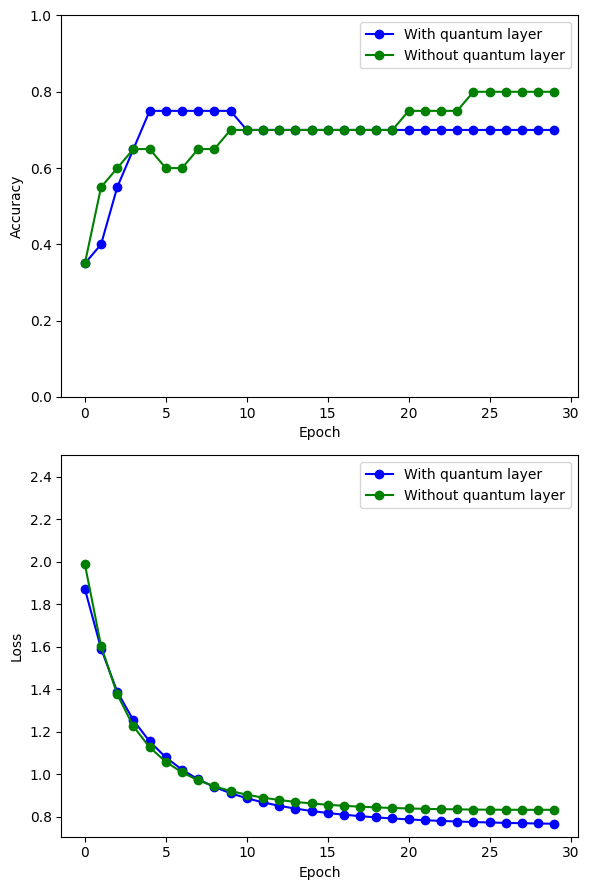

In [33]:
import matplotlib.pyplot as plt

plt.style.use("default")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()